# Modelling

In [1]:
from octis.evaluation_metrics.diversity_metrics import WordEmbeddingsInvertedRBOCentroid, TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence, WECoherenceCentroid
from octis.models.model import load_model_output, save_model_output
from octis.preprocessing.preprocessing import Preprocessing
from octis.optimization.optimizer import Optimizer
from octis.optimization.optimizer_tool import plot_bayesian_optimization, convergence_res
from skopt.space import Integer, Real, Categorical
from octis.dataset.dataset import Dataset
from gensim.models import Word2Vec
from IPython.display import Image
from octis.models.LDA import LDA
from octis.models.CTM import CTM
from octis.models.LSI import LSI
from octis.models.ETM import ETM
from gensim.models import Word2Vec
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter
from joblib import load, dump
import pandas as pd
import numpy as np
import gensim
import string
import spacy
import time
import os
import re

In [2]:
word2vec_model = Word2Vec.load("./word2vec/word2vec_model")
df_ref=pd.read_csv('./preprocessing/results/df_books_prep.csv')
df_input=pd.read_csv('./preprocessing/results/df_books_chunk.csv')

In [5]:
# df_input['tokenized_text'] = df_input['preprocessed_text'].apply(lambda text: text.split())

In order to improve the salience of the results Mimno et all have argued for the importance of filtering a corpus to remove the most freuqent, as well as the most rare terms in order to make for more meaningful results.
As threshhods they have proposed removing the top 5 to 10 percent of most frequent terms, as well as removing everyingth that doens't appear at least 5-10 times in the whole corpus.

In [6]:
# # Create a frequency distribution
# word_freq = Counter(word for doc in df_input['tokenized_text'] for word in doc)

# # Identify words to filter
# total_words = len(word_freq)
# top_5_percent = int(total_words * 0.05)
# most_common_words = set(word for word, freq in word_freq.most_common(top_5_percent))
# least_frequent_words = set(word for word, freq in word_freq.items() if freq < 5)

# # Combine the sets of words to remove
# words_to_remove = most_common_words.union(least_frequent_words)

# # Filter words from each document
# df_input['filtered_tokens'] = df_input['tokenized_text'] .apply(lambda doc: [word for word in doc if word not in words_to_remove])

# # Optionally, rejoin tokens into a single string
# df_input['filtered_text'] = df_input['filtered_tokens'].apply(' '.join)

We start with input for the octis models and will test out a variety of their topic modeling implementations.

In [8]:
# # Writing 'filtered_text' column to 'corpus.txt'
# with open('./octis/corpus.txt', 'w', encoding='utf-8') as corpus_file:
#     for preprocessed_text in df_input['filtered_text']:
#         corpus_file.write(preprocessed_text + '\n')

# #creating an input vocabulary file

# vocabulary = set()

# for text in df_input['filtered_text']:
#     vocabulary.update(text.split())

# with open('./octis/vocabulary.txt', 'w') as vocab_file:
#     for word in sorted(vocabulary):
#         vocab_file.write(word + '\n')

In [40]:
#octis expects a binary, not a model object
#word2vec_model.wv.save_word2vec_format('./word2vec/word2vec_model.bin', binary=True)

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA).

The variant of the dataset for model training and the variant for final later use only differ by the former carrying a split into training, test and validation set.

In [4]:
# preprocessor = Preprocessing(vocabulary=None, save_original_indexes=True, max_features=None,
#                              remove_punctuation=True, punctuation=string.punctuation, 
#                              lemmatize=False, stopword_list='english',
#                              min_chars=1, min_words_docs=0)
# # preprocess
# dataset = Dataset()
# dataset = preprocessor.preprocess_dataset(documents_path=r'/Storage/Studium/DigitalHumanities/Semester5/Thesis/code_notebooks/octis/corpus.txt')

# # # #save the preprocessed dataset

# dump(dataset, './octis/dataset.joblib')
dataset=load('./octis/dataset.joblib')

In [3]:
# preprocessor = Preprocessing(vocabulary=None, save_original_indexes=True, max_features=None,
#                              remove_punctuation=True, punctuation=string.punctuation, 
#                              lemmatize=False, stopword_list='english',split=False, 
#                              min_chars=1, min_words_docs=0)
# # preprocess
# dataset_final = Dataset()
# dataset_final = preprocessor.preprocess_dataset(documents_path=r'/Storage/Studium/DigitalHumanities/Semester5/Thesis/code_notebooks/octis/corpus.txt')

# dump(dataset_final, './octis/dataset_final.joblib')
dataset_final=load('./octis/dataset_final.joblib')

# Model Training

#### LDA

OCTIS - intrinsic pipeline with skopt

In [26]:

# Define the hyperparameter space
parameter_space = {
    'num_topics': Integer(50, 101),  # Range of topics as integer
    'alpha': Real(0.001, 10, prior='uniform'),  # Dirichlet hyperparameter for document-topic distribution
    'eta': Real(0.001, 10, prior='uniform')  # Dirichlet hyperparameter for topic-word distribution
}

# Define the model
lda_model = LDA(num_topics=60, alpha=0.09, eta=5.0)

optimization_runs=200
model_runs=3

#npmi = Coherence(texts=dataset.get_corpus())
coherence_centroid = WECoherenceCentroid(topk=20, word2vec_path='./word2vec/word2vec_model.bin', binary=True)  
#topic_diversity = TopicDiversity(topk=10)
DiversityCentroid=WordEmbeddingsInvertedRBOCentroid(topk=20, weight=0.9, normalize=True, word2vec_path='./word2vec/word2vec_model.bin', binary=True)
#coherece_score = metric_coherence.score(dataset.get_corpus())
# Run the hyperparameter optimization
start = time.time()

optimizer=Optimizer()
optimizer_results_LDA = optimizer.optimize(model=lda_model, dataset=dataset, metric=coherence_centroid, 
                        search_space=parameter_space, number_of_call=optimization_runs, 
                        n_random_starts=5,surrogate_model='RF',
                        model_runs=model_runs, save_models=True, topk=20,
                        extra_metrics=[DiversityCentroid],save_path='./octis/results/', plot_best_seen=True)

end = time.time()
duration = end - start

# Save the results
optimizer_results_LDA.save_to_csv("./octis/results/Opt_LDAresults.csv")

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')


Current call:  0
Current call:  1
Current call:  2
Current call:  3
Current call:  4
Current call:  5
Current call:  6
Current call:  7
Current call:  8
Current call:  9
Current call:  10
Current call:  11
Current call:  12
Current call:  13
Current call:  14
Current call:  15
Current call:  16
Current call:  17
Current call:  18
Current call:  19
Current call:  20
Current call:  21
Current call:  22
Current call:  23
Current call:  24
Current call:  25
Current call:  26
Current call:  27
Current call:  28
Current call:  29
Current call:  30
Current call:  31
Current call:  32
Current call:  33
Current call:  34
Current call:  35
Current call:  36
Current call:  37
Current call:  38
Current call:  39
Current call:  40
Current call:  41
Current call:  42
Current call:  43
Current call:  44
Current call:  45
Current call:  46
Current call:  47
Current call:  48
Current call:  49
Current call:  50
Current call:  51
Current call:  52
Current call:  53
Current call:  54
Current call:  55
Cu

In [7]:
dump(optimizer_results_LDA, './octis/models/optimizer_results_LDA_long.joblib', compress=('lzma', 9))

['./octis/models/optimizer_results_LDA_long.joblib']

In [6]:
optimizer_results_LDA=load('./octis/models/optimizer_results_LDA_long.joblib')

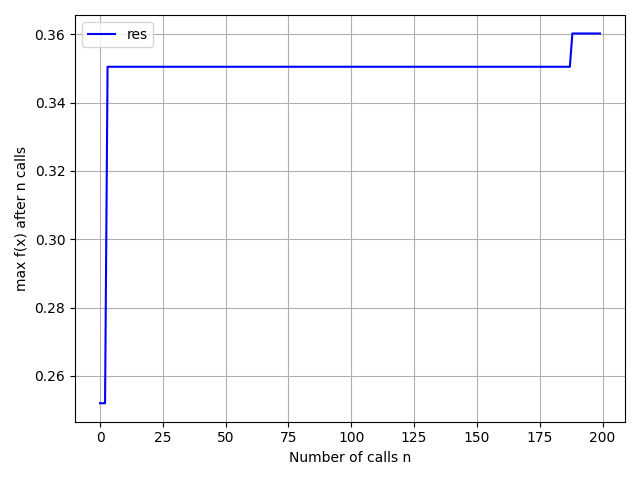

In [35]:
# the optimization process here is one of maximization, yet the provided function for plotting 
# assumes the oposite, so we shall invert the result.

values_to_plot_LDA = [-x for x in optimizer_results_LDA.info['f_val']]

plot_bayesian_optimization(values=values_to_plot_LDA, 
                          name_plot="LDA_Optimization_Convergence", 
                          log_scale=False, 
                          conv_max=True)

Image(filename='LDA_Optimization_Convergence.png')

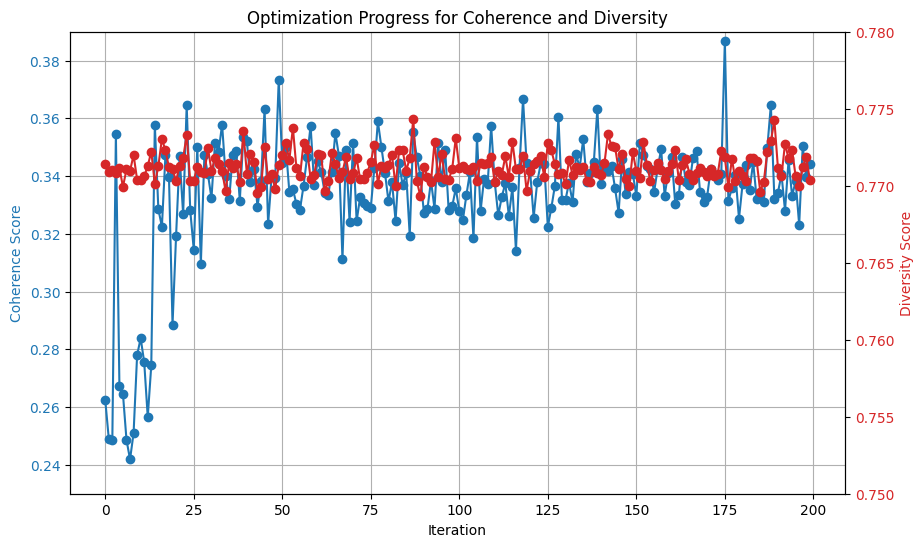

In [30]:
# Plotting WECoherenceCentroid' and 'WordEmbeddingsInvertedRBOCentroid' our two metrics
coherence_scores_LDA = [max(run) for run in optimizer_results_LDA.info['dict_model_runs']['WECoherenceCentroid'].values()]
diversity_scores_LDA = [max(run) for run in optimizer_results_LDA.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid'].values()]

# Create a figure with twin y-axis for the second metric
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Coherence Score', color='tab:blue')
ax1.plot(coherence_scores_LDA, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0.23, 0.39)

ax2 = ax1.twinx() 
ax2.set_ylabel('Diversity Score', color='tab:red')  
ax2.plot(diversity_scores_LDA, marker='o', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0.75, 0.78)

plt.title('Optimization Progress for Coherence and Diversity')
ax1.grid(True)

plt.show()

for the choice of the best hyperparameters, we primarily take the coherence values into account, but use diversity as a form of secondary criterion. Of the ten best coherence scores we shall select the parameter set with the highest diversity score.

In [31]:
# Extract the best configurations based on coherence scores
coherence_scores_LDA = optimizer_results_LDA.info['dict_model_runs']['WECoherenceCentroid']
diversity_scores_LDA = optimizer_results_LDA.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid']

# Extracting scores and hyperparameter configurations
combined_scores = []
for i, (coherence_run, diversity_run) in enumerate(zip(coherence_scores_LDA.values(), diversity_scores_LDA.values())):
    max_coherence = max(coherence_run)
    max_diversity = max(diversity_run)
    alpha = optimizer_results_LDA.info['x_iters']['alpha'][i]
    eta = optimizer_results_LDA.info['x_iters']['eta'][i]
    num_topics = optimizer_results_LDA.info['x_iters']['num_topics'][i]
    combined_scores.append((max_coherence, max_diversity, alpha, eta, num_topics))

# Sort by coherence score first and take the top ten
top_ten_by_coherence = sorted(combined_scores, key=lambda x: x[0], reverse=True)[:10]

# Select the configuration with the highest diversity score from the top ten
best_overall_LDA = max(top_ten_by_coherence, key=lambda x: x[1])

# Print the best configuration
print("Best Coherence Score:", best_overall_LDA[0])
print("Corresponding Diversity Score:", best_overall_LDA[1])
print("Best Configuration: num_topics =", best_overall_LDA[4], ", alpha =", best_overall_LDA[2], ", eta =", best_overall_LDA[3])

Best Coherence Score: 0.3645317335923453
Corresponding Diversity Score: 0.773282116307585
Best Configuration: num_topics = 61 , alpha = 0.009657872773095846 , eta = 9.592299824398896


In [32]:
best_num_topics = best_overall_LDA[4]
best_alpha = best_overall_LDA[2]
best_eta = best_overall_LDA[3]

# Now instantiate the LDA model with the best hyperparameters
best_model_LDA = LDA(num_topics=best_num_topics, 
                 alpha=best_alpha, 
                 eta=best_eta)

# Disable partitioning to use the entire dataset
best_model_LDA.partitioning(use_partitions=False)

# Train the model with the dataset
best_model_LDA = best_model_LDA.train_model(dataset_final)

In [34]:
dump(best_model_LDA,'./octis/models/best_model_LDA_overall.joblib', compress=('lzma', 9))
best_model_LDA = load('./octis/models/best_model_LDA_overall.joblib')

In [36]:
top_words_per_topic_LDA = best_model_LDA['topics']

# Display the top words for each topic
for topic_id, words in enumerate(top_words_per_topic_LDA):
    print("Topic", topic_id + 1, ":", words)

Topic 1 : ['giant', 'agent', 'priests', 'milk', 'robbers', 'cavern', 'betwixt', 'hesitation', 'trial', 'shed']
Topic 2 : ['onnur', 'landlady', 'hearted', 'butter', 'rector', 'scream', 'college', 'luck', 'gathering', 'traced']
Topic 3 : ['canoe', 'coffin', 'purse', 'lawn', 'fortress', 'basin', 'halls', 'pillars', 'bedroom', 'winding']
Topic 4 : ['cavern', 'communication', 'stopping', 'connection', 'picnic', 'warned', 'shaking', 'cries', 'composition', 'withered']
Topic 5 : ['government', 'groan', 'closet', 'fourth', 'can', 'prey', 'hid', 'deceased', 'staff', 'security']
Topic 6 : ['artist', 'nobleman', 'honourable', 'speed', 'terrace', 'quitted', 'lords', 'shortly', 'fruit', 'ride']
Topic 7 : ['cigar', 'sensitive', 'regiment', 'appeal', 'talents', 'she', 'type', 'editor', 'obscure', 'visitors']
Topic 8 : ['princesses', 'cavaliers', 'fortress', 'eldest', 'lovers', 'nephew', 'plague', 'newspaper', 'discreet', 'intercourse']
Topic 9 : ['giant', 'louder', 'rector', 'beating', 'bade', 'thrus

In [37]:
dump(top_words_per_topic_LDA,'./analysis/top_words_per_topic_LDA.joblib')

['./analysis/top_words_per_topic_LDA.joblib']

#### Preparing the results for further analysis

now that we have several variants available, we will have a look at the topic document distribution:

In [80]:
def get_document_topic_percentages(topic_document_matrix):
    
    num_docs = topic_document_matrix.shape[1]
    num_topics = topic_document_matrix.shape[0]
    data = []
    
    # Iterate over each document
    for doc_index in range(topic_document_matrix.shape[1]):
        # Get topic distribution for the document
        topic_distribution = topic_document_matrix[:, doc_index]
        
        data.append([round(percentage * 100, 2) for percentage in topic_distribution])

    column_names = [f"Topic {i}" for i in range(num_topics)]
    df = pd.DataFrame(data, columns=column_names)
    df.index.name = "Document ID"
    return df

In [61]:
topic_document_matrix_LDA = best_model_LDA["topic-document-matrix"]
topic_distribution_df_LDA = get_document_topic_percentages(topic_document_matrix_LDA)
topic_distribution_df_LDA.head(10)

Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  \
Document ID                                                                  
0               0.01     0.01     0.01     6.24     0.01     0.01     0.01   
1               0.00     0.00     0.00     0.00     0.00     0.00     7.34   
2               0.01     0.01     0.01     5.35     0.01     0.01     0.01   
3               0.01     0.01     0.01    21.43     0.01     0.01     0.01   
4               0.01     0.01     0.01    12.40     1.64     0.01     0.05   
...              ...      ...      ...      ...      ...      ...      ...   
956             0.01     0.01     0.01     0.01     0.01     0.01     0.01   
957             0.04     0.04     0.04     0.04     0.04     0.04     0.04   
958             0.04    94.88     0.04     0.04     0.04     0.04     0.04   
959             0.01     0.01     0.01     0.01     0.01     0.01     0.11   
960             0.01     2.72     0.01     0.01     0.01     0.01     0.01   

             Topic 7  Topic 8  Topic 9  ...  Topic 40  Topic 41  Topic 42  \
Document ID                             ...                                 
0               0.01     0.01     0.01  ...      0.01      0.01      0.01   
1               0.00     0.00     0.00  ...      0.06     46.18      0.00   
2               2.19     0.01     0.01  ...      0.01     17.64      0.01   
3               0.01     2.47     0.01  ...      0.01     70.39      0.01   
4               1.86    68.28     0.01  ...      0.01      0.01      0.01   
...              ...      ...      ...  ...       ...       ...       ...   
956             0.01     0.01     0.01  ...      1.32      1.47      0.01   
957             0.04     0.04     0.04  ...      0.04      0.04      0.04   
958             0.04     0.04     0.04  ...      0.04      0.04      0.04   
959             0.01     0.01     0.01  ...      0.01     39.71      0.01   
960             0.01     0.01     0.01  ...      1.68      0.01      0.01   

             Topic 43  Topic 44  Topic 45  Topic 46  Topic 47  Topic 48  \
Document ID                                                               
0                0.01      0.01      0.01      0.01      0.01      0.01   
1                0.00      0.00      0.00      6.53      0.00      2.61   
2               17.73      6.54      0.01      1.13      0.01      0.01   
3                0.01      0.01      0.01      0.01      0.01      0.01   
4                0.01      0.01      0.44      0.09      0.01      0.01   
...               ...       ...       ...       ...       ...       ...   
956              0.01      0.01      0.01      0.01      0.01      2.99   
957              0.04      0.04      0.04      0.04      0.04      0.04   
958              0.04      0.04      0.04      0.04      0.04      0.04   
959              0.01      0.01      4.42      0.01      0.01      0.01   
960              0.01      0.01      0.01      0.01      0.01      0.01   

             Topic 49  
Document ID            
0                0.01  
1                0.00  
2                0.01  
3                0.01  
4                4.09  
...               ...  
956              0.01  
957              0.04  
958              0.04  
959              0.01  
960              0.01  

[961 rows x 50 columns]

In [ ]:
original_indexes = dataset_final._Dataset__original_indexes
topic_distribution_df_LDA['Original Document Index'] = original_indexes

The rows of the original document are sampled at a random order when passed into the preprocessor in case the default split=True is set and thus the document order is scrabled, but if this parameter is set to False, the order of ducments is maintained and can be easily joined. For safeties sake, we will join according to order of the indices function nonetheless.

In [ ]:
# df_input['input_index'] = df_input.index
# df_input['ref'] = df_input['reference'].apply(lambda x: x.rsplit('_', 1)[0])
# df_merge = df_input.merge(df_ref, left_on='ref', right_on='reference', how='left')
# df_merge['date'] = df_merge['date'].astype('Int64')
# df_merge['birthdate'] = df_merge['birthdate'].astype('Int64')
# df_merge.head()

In [ ]:
# # merging of topic distribution with features
# # reorganizing the order of columns and clean up
# df_txt_features_LDA = df_merge.merge(topic_distribution_df, right_on='Original Document Index', left_on='input_index')
# df_txt_features_LDA=df_txt_features_LDA.drop(['text', 'preprocessed_text_y','tokenized_text','preprocessed_text_x', 'index', 'ref', 'Original Document Index'], axis=1)
# df_txt_features_LDA.rename(columns={'reference_x': 'reference','reference_y': 'text_key'}, inplace=True)
# df_txt_features_LDA = df_txt_features_LDA[['input_index'] + [col for col in df_txt_features_LDA.columns if col != 'input_index']]
# df_txt_features_LDA.head()

In [ ]:
#df_txt_features_LDA.to_csv('./analysis/df_txt_features_LDA.csv', index=False)

#### creating exportable model elements for use in pyLDAdavis

In [52]:
topic_term_dists_LDA= best_model_LDA["topic-document-matrix"]
doc_topic_dists_LDA = best_model_LDA["topic-word-matrix"]
vocab = dataset_final.get_vocabulary()
doc_lengths = [len(doc) for doc in dataset_final.get_corpus()]

In [54]:
corpus = dataset_final.get_corpus()

# Initialize term frequency dictionary
term_frequency_dict = {term: 0 for term in vocab}

# Count the frequency of each term in the corpus
for document in corpus:
    for word in document:
        if word in term_frequency_dict:
            term_frequency_dict[word] += 1

# Convert term frequencies to a list in the order of the vocabulary
term_frequency= [term_frequency_dict[word] for word in vocab]

Export for the analysis

In [63]:
dump(topic_term_dists_LDA, './analysis/topic_term_dists_LDA.joblib')
dump(doc_topic_dists_LDA, './analysis/doc_topic_dists_LDA.joblib')
dump(vocab, './analysis/vocab.joblib')
dump(doc_lengths, './analysis/doc_lengths.joblib')
dump(term_frequency, './analysis/term_frequency.joblib')

['./octis/results/term_frequency.joblib']

#### CTM

In [44]:
# Initialize the CTM model with some default parameters
ctm_model = CTM(batch_size=128, num_epochs=30, inference_type='zeroshot', bert_model="bert-base-nli-mean-tokens")

# Define the hyperparameter space for CTM
parameter_space = {
    'num_topics': Integer(50, 100),
    'num_layers': Categorical([1, 2, 3]),
    'num_neurons': Categorical([100, 200, 300, 500, 750, 1000]),
    'learn_rate':Real(0.001, 0.1), 
    'optimizer': Categorical(['adam', 'sgd', 'msprop']),
    'dropout': Real(0.0, 0.9, prior='uniform')
}

# Define the evaluation metric
coherence_centroid = WECoherenceCentroid(topk=20, word2vec_path='./word2vec/word2vec_model.bin', binary=True)
DiversityCentroid = WordEmbeddingsInvertedRBOCentroid(topk=20, weight=0.9, normalize=True, word2vec_path='./word2vec/word2vec_model.bin', binary=True)

# Run the hyperparameter optimization
start = time.time()

optimizer = Optimizer()
optimizer_results_CTM = optimizer.optimize(model=ctm_model, dataset=dataset, metric=coherence_centroid, 
                        search_space=parameter_space, number_of_call=200, 
                        n_random_starts=5, surrogate_model='RF',
                        model_runs=3, save_models=True, topk=20,
                        extra_metrics=[DiversityCentroid], save_path='./octis/results/', plot_best_seen=True)

end = time.time()
duration = end - start

# Save the results
optimizer_results_CTM.save_to_csv("./octis/results/Opt_CTMresults.csv")

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

Current call:  0
Current call:  1
Current call:  2
Current call:  3
Current call:  4
Current call:  5
Current call:  6
Current call:  7
Current call:  8
Current call:  9
Current call:  10
Current call:  11
Current call:  12
Current call:  13
Current call:  14
Current call:  15
Current call:  16
Current call:  17
Current call:  18
Current call:  19
Current call:  20
Current call:  21
Current call:  22
Current call:  23
Current call:  24
Current call:  25
Current call:  26
Current call:  27
Current call:  28
Current call:  29
Current call:  30
Current call:  31
Current call:  32
Current call:  33
Current call:  34
Current call:  35
Current call:  36
Current call:  37
Current call:  38
Current call:  39
Current call:  40
Current call:  41
Current call:  42
Current call:  43
Current call:  44
Current call:  45
Current call:  46
Current call:  47
Current call:  48
Current call:  49
Current call:  50
Current call:  51
Current call:  52
Current call:  53
Current call:  54
Current call:  55
Cu

In [46]:
dump(optimizer_results_CTM, './octis/models/optimizer_results_CTM.joblib', compress=('lzma', 9))

In [36]:
optimizer_results_CTM = load('./octis/models/optimizer_results_CTM.joblib')

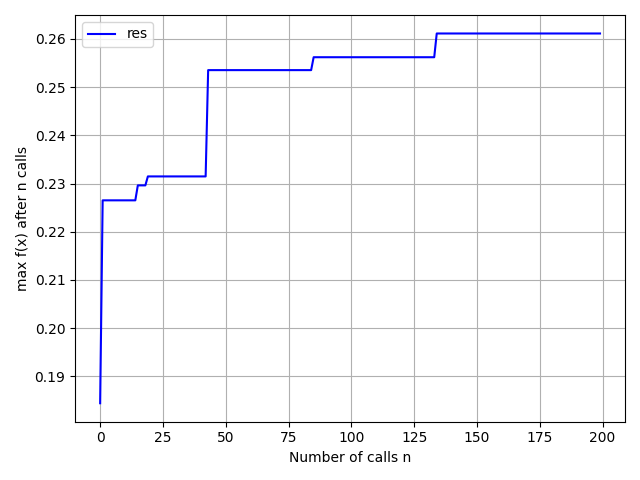

In [38]:
# the optimization process here is one of maximization, yet the provided function for plotting 
# assumes the oposite, so we shall invert the result.

values_to_plot_CTM = [-x for x in optimizer_results_CTM.info['f_val']]

plot_bayesian_optimization(values=values_to_plot_CTM, 
                          name_plot="CTM_Optimization_Convergence", 
                          log_scale=False, 
                          conv_max=True)

Image(filename='CTM_Optimization_Convergence.png')

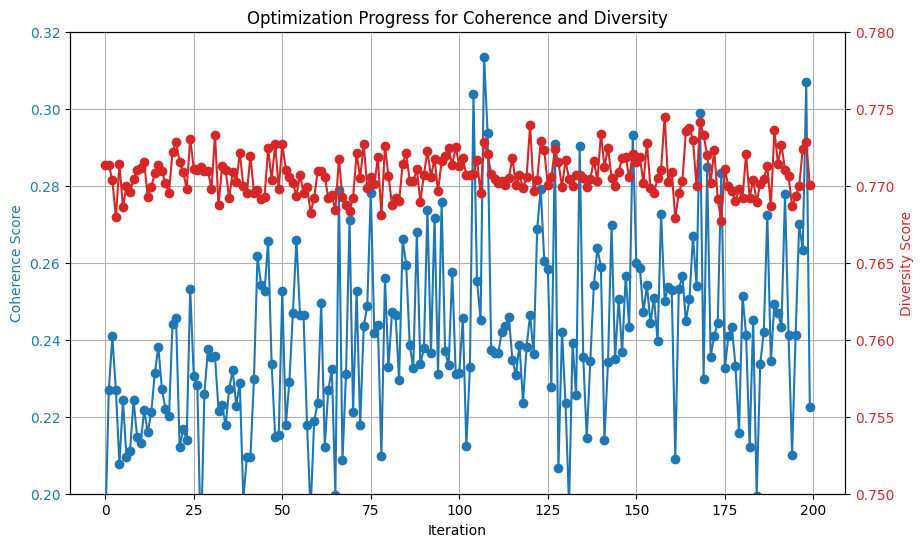

In [48]:
# Plotting WECoherenceCentroid' and 'WordEmbeddingsInvertedRBOCentroid' our two metrics
coherence_scores_CTM = [max(run) for run in optimizer_results_CTM.info['dict_model_runs']['WECoherenceCentroid'].values()]
diversity_scores_CTM = [max(run) for run in optimizer_results_CTM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid'].values()]

# Create a figure with twin y-axis for the second metric
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Coherence Score', color='tab:blue')
ax1.plot(coherence_scores_CTM, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0.20, 0.32)

ax2 = ax1.twinx() 
ax2.set_ylabel('Diversity Score', color='tab:red')  
ax2.plot(diversity_scores_CTM, marker='o', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0.75, 0.78)

plt.title('Optimization Progress for Coherence and Diversity')
ax1.grid(True)

plt.show()

In [51]:
# Extract the best configurations based on coherence scores
coherence_scores_CTM = optimizer_results_CTM.info['dict_model_runs']['WECoherenceCentroid']
diversity_scores_CTM = optimizer_results_CTM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid']

# Extracting scores and hyperparameter configurations
combined_scores = []
for i, (coherence_run, diversity_run) in enumerate(zip(coherence_scores_CTM.values(), diversity_scores_CTM.values())):
    max_coherence = max(coherence_run)
    max_diversity = max(diversity_run)
    num_topics = optimizer_results_CTM.info['x_iters']['num_topics'][i]
    num_layers = optimizer_results_CTM.info['x_iters']['num_layers'][i]
    num_neurons = optimizer_results_CTM.info['x_iters']['num_neurons'][i]
    learn_rate = optimizer_results_CTM.info['x_iters']['learn_rate'][i]
    optimizer_param = optimizer_results_CTM.info['x_iters']['optimizer'][i]
    dropout = optimizer_results_CTM.info['x_iters']['dropout'][i]
   
    combined_scores.append((max_coherence, max_diversity, num_topics, num_layers, num_neurons, learn_rate, optimizer_param, dropout, alpha, eta))

# Sort by coherence score first and take the top ten
top_ten_by_coherence = sorted(combined_scores, key=lambda x: x[0], reverse=True)[:10]

# Select the configuration with the highest diversity score from the top ten
best_overall_CTM = max(top_ten_by_coherence, key=lambda x: x[1])

# Print the best configuration
print("Best Coherence Score:", best_overall_CTM[0])
print("Corresponding Diversity Score:", best_overall_CTM[1])
print("Best Configuration: num_topics =", best_overall_CTM[2], ", num_layers =", best_overall_CTM[3], ", num_neurons =", best_overall_CTM[4], 
      ", learn_rate =", best_overall_CTM[5], ", optimizer =", best_overall_CTM[6], ", dropout =", best_overall_CTM[7])


Best Coherence Score: 0.29890572437804974
Corresponding Diversity Score: 0.774159710592623
Best Configuration: num_topics = 52 , num_layers = 3 , num_neurons = 300 , learn_rate = 0.0497584974583267 , optimizer = adam , dropout = 0.8844994878180923


In [ ]:
best_num_topics = best_overall_CTM[2]
best_num_layers = best_overall_CTM[3]
best_num_neurons = best_overall_CTM[4]
best_learn_rate = best_overall_CTM[5]
best_optimizer = best_overall_CTM[6]
best_dropout = best_overall_CTM[7]

# Now we instantiate the CTM model with the best hyperparameters
best_model_CTM = CTM(num_topics=best_num_topics,
                     num_layers=best_num_layers,
                     num_neurons=best_num_neurons,
                     solver=best_optimizer,
                     dropout=best_dropout, 
                     batch_size=128,
                     use_partitions=False,
                     bert_path='./octis/models/')

# Train the model with the dataset
best_model_CTM = best_model_CTM.train_model(dataset_final)

In [75]:
dump(best_model_CTM, './octis/models/best_model_CTM.joblib', compress=('lzma', 9))
best_model_CTM = load('./octis/models/best_model_CTM.joblib')

In [76]:
top_words_per_topic_CTM = best_model_CTM['topics']

# Display the top words for each topic
for topic_id, words in enumerate(top_words_per_topic_CTM):
    print("Topic", topic_id + 1, ":", words)

Topic 1 : ['jumped', 'shaking', 'inches', 'bedroom', 'joke', 'seconds', 'trap', 'handkerchief', 'detail', 'inquiry']
Topic 2 : ['standard', 'elegant', 'respecting', 'distinction', 'indulgence', 'writers', 'illustrious', 'graceful', 'honourable', 'arts']
Topic 3 : ['club', 'shouted', 'smell', 'hit', 'trousers', 'statement', 'desk', 'shaking', 'groaned', 'diary']
Topic 4 : ['hit', 'settle', 'suggestion', 'pull', 'sentry', 'silk', 'newspaper', 'twisted', 'tight', 'agent']
Topic 5 : ['baby', 'piano', 'cab', 'fun', 'pick', 'upstairs', 'heels', 'baroness', 'advertisement', 'clever']
Topic 6 : ['brute', 'landlord', 'trousers', 'color', 'gown', 'shakes', 'plaster', 'porter', 'desk', 'oil']
Topic 7 : ['upstairs', 'overhead', 'steady', 'louder', 'canoe', 'landlady', 'bedroom', 'coffin', 'slightly', 'lowered']
Topic 8 : ['tricks', 'starting', 'knocked', 'newspaper', 'landlord', 'shows', 'medical', 'darkened', 'poured', 'mischief']
Topic 9 : ['angels', 'resemblance', 'poets', 'hath', 'text', 'fort

In [78]:
dump(top_words_per_topic_CTM,'./analysis/top_words_per_topic_CTM.joblib')

['./analysis/top_words_per_topic_CTM.joblib']

In [81]:
topic_document_matrix_CTM = best_model_CTM["topic-document-matrix"]
topic_distribution_df_CTM = get_document_topic_percentages(topic_document_matrix_CTM)
topic_distribution_df_CTM.head(10)

Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  \
Document ID                                                                  
0               7.26     1.01     2.08     2.13     1.27     2.55     8.09   
1               2.71     0.67     3.65     3.67     2.04     1.59     3.57   
2               0.47     2.24     0.35     0.18     0.76     0.87     0.41   
3               0.20     1.29     0.42     0.21     0.26     0.37     0.10   
4               0.62     3.20     0.61     1.83     0.69     0.77     0.28   
5               3.97     0.44     2.93     2.51     2.60     2.53     2.73   
6               0.24     2.16     0.34     0.26     0.41     0.53     0.21   
7               0.16     2.50     0.07     0.34     0.20     0.41     0.14   
8               1.01     4.34     1.38     0.89     1.38     1.76     1.28   
9               0.67     5.54     1.92     1.98     0.91     1.76     1.18   

             Topic 7  Topic 8  Topic 9  ...  Topic 42  Topic 43  Topic 44  \
Document ID                             ...                                 
0               2.73     0.74     4.06  ...      2.74      9.08      4.70   
1               3.58     1.30     2.77  ...      2.14      1.83      1.96   
2               0.17     0.88     0.48  ...      0.32      0.23      0.37   
3               0.17     2.88     0.23  ...      0.22      0.15      0.13   
4               0.28     1.64     0.89  ...      0.47      0.28      0.50   
5               2.85     0.61     1.69  ...      2.65      8.82      2.27   
6               0.13     3.35     0.43  ...      0.44      0.20      0.28   
7               0.13     1.81     0.18  ...      0.19      0.07      0.07   
8               0.96     2.08     1.07  ...      0.81      1.60      0.44   
9               1.26     3.37     0.97  ...      0.96      0.81      1.98   

             Topic 45  Topic 46  Topic 47  Topic 48  Topic 49  Topic 50  \
Document ID                                                               
0                5.91      3.39      0.48      0.53      0.65      0.39   
1                2.17      1.58      1.72      0.87      0.79      0.89   
2                0.19      0.31      6.58      1.72      3.12      0.91   
3                0.17      0.16      7.98      2.63      1.69      1.81   
4                0.47      0.25      2.72      1.42      3.26      2.41   
5               14.80      2.27      0.33      0.53      0.57      0.35   
6                0.23      0.14      2.41      1.08      4.64      4.42   
7                0.10      0.14      2.88      5.20      8.35      1.26   
8                0.91      0.90      3.15      2.18      3.61      2.65   
9                1.11      0.54      3.61      2.21      1.86      1.56   

             Topic 51  
Document ID            
0                2.83  
1                3.41  
2                0.38  
3                0.19  
4                0.41  
5                3.97  
6                0.17  
7                0.14  
8                1.56  
9                0.39  

[10 rows x 52 columns]

In [82]:
original_indexes = dataset_final._Dataset__original_indexes
topic_distribution_df_CTM['Original Document Index'] = original_indexes

In [85]:
# df_input['input_index'] = df_input.index
# df_input['ref'] = df_input['reference'].apply(lambda x: x.rsplit('_', 1)[0])
# df_merge = df_input.merge(df_ref, left_on='ref', right_on='reference', how='left')
# df_merge['date'] = df_merge['date'].astype('Int64')
# df_merge['birthdate'] = df_merge['birthdate'].astype('Int64')
# df_merge.head()

preprocessed_text_x             reference_x  \
0  fragment adventure turned steed hoping cross d...      Aikin_SirBertran_1   
1  plague portion ensuing relating street manner ...  Ainsworth_OldSaintPa_1   
2  men recovered confusion thrown alarmed indiscr...  Ainsworth_OldSaintPa_2   
3  lived master marriage strongest attachment hal...  Ainsworth_OldSaintPa_3   
4  tiers rising divisions telescope angle support...  Ainsworth_OldSaintPa_4   

   input_index                   ref  index           reference_y  \
0            0      Aikin_SirBertran      0      Aikin_SirBertran   
1            1  Ainsworth_OldSaintPa      1  Ainsworth_OldSaintPa   
2            2  Ainsworth_OldSaintPa      1  Ainsworth_OldSaintPa   
3            3  Ainsworth_OldSaintPa      1  Ainsworth_OldSaintPa   
4            4  Ainsworth_OldSaintPa      1  Ainsworth_OldSaintPa   

                                               title  \
0                           Sir Bertrand, A Fragment   
1  Old Saint Paul's: A Tale of the Plague and the...   
2  Old Saint Paul's: A Tale of the Plague and the...   
3  Old Saint Paul's: A Tale of the Plague and the...   
4  Old Saint Paul's: A Tale of the Plague and the...   

                          author  date    period      mode   genre gender  \
0  Aikin, John and Anna Laetitia  1773  Romantic  Fragment  Gothic    NaN   
1    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
2    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
3    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
4    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   

   birthdate nationality role (central/peripheral/influence)  \
0       <NA>     English                             Central   
1       1805     English                                 NaN   
2       1805     English                                 NaN   
3       1805     English                                 NaN   
4       1805     English                                 NaN   

                                                text     source  \
0  SIR BERTRAND, A FRAGMENT:\n\nAFTER this advent...     colors   
1  OLD SAINT PAUL\'S\n\n  _A TALE OF THE PLAGUE\n...  pb-manual   
2  OLD SAINT PAUL\'S\n\n  _A TALE OF THE PLAGUE\n...  pb-manual   
3  OLD SAINT PAUL\'S\n\n  _A TALE OF THE PLAGUE\n...  pb-manual   
4  OLD SAINT PAUL\'S\n\n  _A TALE OF THE PLAGUE\n...  pb-manual   

                                 preprocessed_text_y  \
0  fragment adventure turned steed hoping cross d...   
1  plague portion ensuing relating street manner ...   
2  plague portion ensuing relating street manner ...   
3  plague portion ensuing relating street manner ...   
4  plague portion ensuing relating street manner ...   

                                      tokenized_text  
0  ['fragment', 'adventure', 'turned', 'steed', '...  
1  ['plague', 'portion', 'ensuing', 'relating', '...  
2  ['plague', 'portion', 'ensuing', 'relating', '...  
3  ['plague', 'portion', 'ensuing', 'relating', '...  
4  ['plague', 'portion', 'ensuing', 'relating', '...

In [87]:
# # merging of topic distribution with features
# # reorganizing the order of columns and clean up
# df_txt_features_CTM= df_merge.merge(topic_distribution_df_CTM, right_on='Original Document Index', left_on='input_index')
# df_txt_features_CTM=df_txt_features_CTM.drop(['text', 'preprocessed_text_y','tokenized_text','preprocessed_text_x', 'index', 'ref', 'Original Document Index'], axis=1)
# df_txt_features_CTM.rename(columns={'reference_x': 'reference','reference_y': 'text_key'}, inplace=True)
# df_txt_features_CTM = df_txt_features_CTM[['input_index'] + [col for col in df_txt_features_CTM.columns if col != 'input_index']]
# df_txt_features_CTM.head()

input_index               reference              text_key  \
0            0      Aikin_SirBertran_1      Aikin_SirBertran   
1            1  Ainsworth_OldSaintPa_1  Ainsworth_OldSaintPa   
2            2  Ainsworth_OldSaintPa_2  Ainsworth_OldSaintPa   
3            3  Ainsworth_OldSaintPa_3  Ainsworth_OldSaintPa   
4            4  Ainsworth_OldSaintPa_4  Ainsworth_OldSaintPa   

                                               title  \
0                           Sir Bertrand, A Fragment   
1  Old Saint Paul's: A Tale of the Plague and the...   
2  Old Saint Paul's: A Tale of the Plague and the...   
3  Old Saint Paul's: A Tale of the Plague and the...   
4  Old Saint Paul's: A Tale of the Plague and the...   

                          author  date    period      mode   genre gender  \
0  Aikin, John and Anna Laetitia  1773  Romantic  Fragment  Gothic    NaN   
1    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
2    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
3    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
4    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   

   ...  Topic 42 Topic 43 Topic 44 Topic 45  Topic 46  Topic 47  Topic 48  \
0  ...      2.74     9.08     4.70     5.91      3.39      0.48      0.53   
1  ...      2.14     1.83     1.96     2.17      1.58      1.72      0.87   
2  ...      0.32     0.23     0.37     0.19      0.31      6.58      1.72   
3  ...      0.22     0.15     0.13     0.17      0.16      7.98      2.63   
4  ...      0.47     0.28     0.50     0.47      0.25      2.72      1.42   

   Topic 49  Topic 50  Topic 51  
0      0.65      0.39      2.83  
1      0.79      0.89      3.41  
2      3.12      0.91      0.38  
3      1.69      1.81      0.19  
4      3.26      2.41      0.41  

[5 rows x 66 columns]

In [88]:
# df_txt_features_CTM.to_csv('./analysis/df_txt_features_CTM.csv', index=False)
# df_txt_features_CTM=pd.read_csv('./analysis/df_txt_features_CTM.csv')

pyLDAvis exports

In [83]:
topic_term_dists_CTM = best_model_CTM["topic-document-matrix"]
doc_topic_dists_CTM = best_model_CTM["topic-word-matrix"]

In [84]:
dump(topic_term_dists_CTM, './analysis/topic_term_dists_CTM.joblib')
dump(doc_topic_dists_CTM, './analysis/doc_topic_dists_CTM.joblib')

['./analysis/doc_topic_dists_CTM.joblib']

#### ETM

In [93]:
# Initialize the CTM model with some default parameters
etm_model = ETM(batch_size=128, num_epochs=30, embeddings_path='word2vec_model.bin')

# Define the hyperparameter space for CTM
parameter_space = {
    'num_topics': Integer(50, 100),
    'num_layers': Categorical([1, 2, 3]),
    'num_neurons': Categorical([100, 200, 300, 500, 750, 1000]),
    'learn_rate':Real(0.001, 0.1), 
    'activation': Categorical(['sigmoid', 'softplus', 'selu']),
    'optimizer': Categorical(['adam', 'sgd', 'msprop']),
    'dropout': Real(0.0, 0.9, prior='uniform')
}


# Define the evaluation metric
coherence_centroid = WECoherenceCentroid(topk=20, word2vec_path='./word2vec/word2vec_model.bin', binary=True)
DiversityCentroid = WordEmbeddingsInvertedRBOCentroid(topk=20, weight=0.9, normalize=True, word2vec_path='./word2vec/word2vec_model.bin', binary=True)

# Run the hyperparameter optimization
start = time.time()

optimizer = Optimizer()
optimizer_results_ETM = optimizer.optimize(model=etm_model, dataset=dataset, metric=coherence_centroid, 
                        search_space=parameter_space, number_of_call=100, 
                        n_random_starts=5, surrogate_model='RF',
                        model_runs=3, save_models=True, topk=20,
                        extra_metrics=[DiversityCentroid], save_path='./octis/results/', plot_best_seen=True)

end = time.time()
duration = end - start

# Save the results
optimizer_results_ETM.save_to_csv("./octis/results/Opt_ETMresults.csv")

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

Current call:  0
model: ETM(
  (t_drop): Dropout(p=0.4555880049221471, inplace=False)
  (theta_act): Softplus(beta=1, threshold=20)
  (rho): Linear(in_features=300, out_features=16283, bias=False)
  (alphas): Linear(in_features=300, out_features=97, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=16283, out_features=800, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
  (mu_q_theta): Linear(in_features=800, out_features=97, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=97, bias=True)
)
Defaulting to vanilla SGD
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 14.57 .. Rec_loss: 2909.9 .. NELBO: 2924.47
****************************************************************************************************
************************************************

In [94]:
dump(optimizer_results_ETM, './octis/models/optimizer_results_ETM.joblib', compress=('lzma', 9))

In [39]:
optimizer_results_ETM = load('./octis/models/optimizer_results_ETM.joblib')

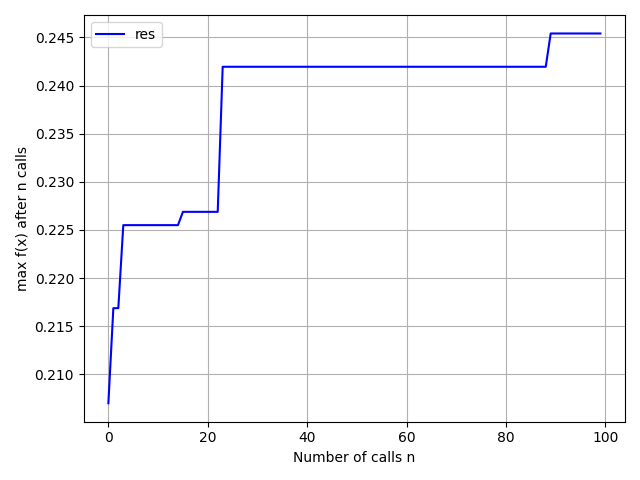

In [40]:
# the optimization process here is one of maximization, yet the provided function for plotting 
# assumes the oposite, so we shall invert the result.

values_to_plot_ETM = [-x for x in optimizer_results_ETM.info['f_val']]

plot_bayesian_optimization(values=values_to_plot_ETM, 
                          name_plot="ETM_Optimization_Convergence", 
                          log_scale=False, 
                          conv_max=True)

Image(filename='ETM_Optimization_Convergence.png')

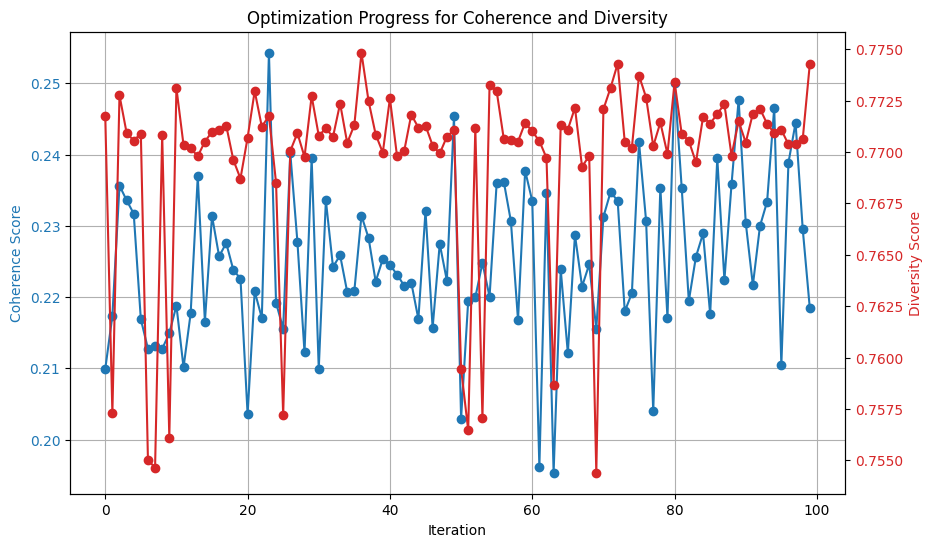

In [95]:
# Plotting WECoherenceCentroid' and 'WordEmbeddingsInvertedRBOCentroid' our two metrics
coherence_scores_ETM = [max(run) for run in optimizer_results_ETM.info['dict_model_runs']['WECoherenceCentroid'].values()]
diversity_scores_ETM = [max(run) for run in optimizer_results_ETM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid'].values()]

# Create a figure with twin y-axis for the second metric
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Coherence Score', color='tab:blue')
ax1.plot(coherence_scores_ETM, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
#ax1.set_ylim(0.23, 0.39)

ax2 = ax1.twinx() 
ax2.set_ylabel('Diversity Score', color='tab:red')  
ax2.plot(diversity_scores_ETM, marker='o', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
#ax2.set_ylim(0.75, 0.78)

plt.title('Optimization Progress for Coherence and Diversity')
ax1.grid(True)

plt.show()

In [98]:
# Extract the best configurations based on coherence scores
coherence_scores_ETM = optimizer_results_ETM.info['dict_model_runs']['WECoherenceCentroid']
diversity_scores_ETM = optimizer_results_ETM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid']

# Extracting scores and hyperparameter configurations
combined_scores = []
for i, (coherence_run, diversity_run) in enumerate(zip(coherence_scores_ETM.values(), diversity_scores_ETM.values())):
    max_coherence = max(coherence_run)
    max_diversity = max(diversity_run)
    num_topics = optimizer_results_ETM.info['x_iters']['num_topics'][i]
    num_layers = optimizer_results_ETM.info['x_iters']['num_layers'][i]
    num_neurons = optimizer_results_ETM.info['x_iters']['num_neurons'][i]
    learn_rate = optimizer_results_ETM.info['x_iters']['learn_rate'][i]
    activation = optimizer_results_ETM.info['x_iters']['activation'][i]
    optimizer_param = optimizer_results_ETM.info['x_iters']['optimizer'][i]
    dropout = optimizer_results_ETM.info['x_iters']['dropout'][i]
    
    combined_scores.append((max_coherence, max_diversity, num_topics, num_layers, num_neurons, learn_rate, activation, optimizer_param, dropout))

# Sort by coherence score first and take the top ten
top_ten_by_coherence = sorted(combined_scores, key=lambda x: x[0], reverse=True)[:10]

# Select the configuration with the highest diversity score from the top ten
best_overall_ETM = max(top_ten_by_coherence, key=lambda x: x[1])

# Print the best configuration
print("Best Coherence Score:", best_overall_ETM[0])
print("Corresponding Diversity Score:", best_overall_ETM[1])
print("Best Configuration: num_topics =", best_overall_ETM[2], 
      ", num_layers =", best_overall_ETM[3],
      ", num_neurons =", best_overall_ETM[4],
      ", learn_rate =", best_overall_ETM[5],
      ", activation =", best_overall_ETM[6],
      ", optimizer =", best_overall_ETM[7],
      ", dropout =", best_overall_ETM[8])


Best Coherence Score: 0.24174463417655498
Corresponding Diversity Score: 0.7737157557456279
Best Configuration: num_topics = 56 , num_layers = 1 , num_neurons = 100 , learn_rate = 0.06695276068179805 , activation = sigmoid , optimizer = sgd , dropout = 0.5239692674282411


In [107]:
best_overall_ETMbest_num_topics = [2]
best_num_layers = best_overall_ETM[3]
best_num_neurons = best_overall_ETM[4]
best_learn_rate = best_overall_ETM[5]
best_activation = best_overall_ETM[6]
best_optimizer = best_overall_ETM[7]
best_dropout = best_overall_ETM[8]

# Now we instantiate the ETM model with the best hyperparameters
best_model_ETM = ETM(num_topics=best_num_topics,
                     #num_layers=best_num_layers,
                     #num_neurons=best_num_neurons,
                     #solver=best_optimizer,
                     activation=best_activation,
                     dropout=best_dropout, 
                     batch_size=128,
                     use_partitions=False,
                     embeddings_path='word2vec_model.bin',
                     )

# Train the model with the dataset
best_model_ETM = best_model_ETM.train_model(dataset_final)

model: ETM(
  (t_drop): Dropout(p=0.5239692674282411, inplace=False)
  (theta_act): Sigmoid()
  (rho): Linear(in_features=300, out_features=16283, bias=False)
  (alphas): Linear(in_features=300, out_features=52, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=16283, out_features=800, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): Sigmoid()
  )
  (mu_q_theta): Linear(in_features=800, out_features=52, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=52, bias=True)
)
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 9.92 .. Rec_loss: 2892.73 .. NELBO: 2902.65
****************************************************************************************************
****************************************************************************************************
Epoch----->2 .. LR: 0.005 .. KL_theta: 0.03 .. Rec_lo

In [108]:
dump(best_model_ETM, './octis/models/best_model_ETM.joblib', compress=('lzma', 9))
best_model_ETM = load('./octis/models/best_model_ETM.joblib')

In [110]:
top_words_per_topic_ETM = best_model_ETM['topics']

# Display the top words for each topic
for topic_id, words in enumerate(top_words_per_topic_ETM):
    print("Topic", topic_id + 1, ":", words)

Topic 1 : ['dared', 'stock', 'special', 'motives', 'gleam', 'coffin', 'quality', 'shed', 'connection', 'record']
Topic 2 : ['arranged', 'plans', 'risen', 'distinct', 'earlier', 'coffin', 'vivid', 'insisted', 'accomplished', 'credit']
Topic 3 : ['stick', 'coffin', 'outer', 'grasp', 'scorn', 'motionless', 'vengeance', 'arranged', 'tones', 'pillow']
Topic 4 : ['grasp', 'destruction', 'coffin', 'arranged', 'withdrew', 'feeble', 'overcome', 'pleasures', 'secretary', 'wept']
Topic 5 : ['arranged', 'tide', 'absent', 'credit', 'flash', 'threshold', 'fortunate', 'committed', 'grasp', 'belonged']
Topic 6 : ['coffin', 'arranged', 'flash', 'hearth', 'absent', 'ice', 'renewed', 'ruined', 'continually', 'entire']
Topic 7 : ['secretary', 'stock', 'special', 'coffin', 'reception', 'bedroom', 'italian', 'continually', 'supply', 'muttered']
Topic 8 : ['earlier', 'gathering', 'motives', 'stock', 'mile', 'occupation', 'hearth', 'housekeeper', 'supply', 'steady']
Topic 9 : ['credit', 'impressed', 'mile', '

In [111]:
dump(top_words_per_topic_ETM,'./analysis/top_words_per_topic_ETM.joblib')

['./analysis/top_words_per_topic_ETM.joblib']

In [112]:
topic_document_matrix_ETM = best_model_ETM["topic-document-matrix"]
topic_distribution_df_ETM = get_document_topic_percentages(topic_document_matrix_ETM)
topic_distribution_df_ETM.head(10)

Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  \
Document ID                                                                  
0               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
1               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
2               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
3               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
4               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
5               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
6               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
7               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
8               1.92     1.92     1.92     1.92     1.92     1.92     1.92   
9               1.92     1.92     1.92     1.92     1.92     1.92     1.92   

             Topic 7  Topic 8  Topic 9  ...  Topic 42  Topic 43  Topic 44  \
Document ID                             ...                                 
0               1.92     1.92     1.92  ...      1.92      1.93      1.91   
1               1.92     1.92     1.92  ...      1.92      1.93      1.91   
2               1.92     1.92     1.92  ...      1.92      1.93      1.91   
3               1.92     1.92     1.92  ...      1.92      1.93      1.91   
4               1.92     1.92     1.92  ...      1.92      1.93      1.91   
5               1.92     1.92     1.92  ...      1.92      1.93      1.91   
6               1.92     1.92     1.92  ...      1.92      1.93      1.91   
7               1.92     1.92     1.92  ...      1.92      1.93      1.91   
8               1.92     1.92     1.92  ...      1.92      1.93      1.91   
9               1.92     1.92     1.92  ...      1.92      1.93      1.91   

             Topic 45  Topic 46  Topic 47  Topic 48  Topic 49  Topic 50  \
Document ID                                                               
0                1.92      1.92      1.92      1.92      1.93      1.92   
1                1.92      1.92      1.92      1.92      1.93      1.92   
2                1.92      1.92      1.92      1.92      1.93      1.92   
3                1.92      1.92      1.92      1.92      1.93      1.92   
4                1.92      1.92      1.92      1.92      1.93      1.92   
5                1.92      1.92      1.92      1.92      1.93      1.92   
6                1.92      1.92      1.92      1.92      1.93      1.92   
7                1.92      1.92      1.92      1.92      1.93      1.92   
8                1.92      1.92      1.92      1.92      1.93      1.92   
9                1.92      1.92      1.92      1.92      1.93      1.92   

             Topic 51  
Document ID            
0                1.92  
1                1.92  
2                1.92  
3                1.92  
4                1.92  
5                1.92  
6                1.92  
7                1.92  
8                1.92  
9                1.92  

[10 rows x 52 columns]

In [113]:
original_indexes = dataset_final._Dataset__original_indexes
topic_distribution_df_ETM['Original Document Index'] = original_indexes

In [ ]:
# df_input['input_index'] = df_input.index
# df_input['ref'] = df_input['reference'].apply(lambda x: x.rsplit('_', 1)[0])
# df_merge = df_input.merge(df_ref, left_on='ref', right_on='reference', how='left')
# df_merge['date'] = df_merge['date'].astype('Int64')
# df_merge['birthdate'] = df_merge['birthdate'].astype('Int64')
# df_merge.head()

In [115]:
# merging of topic distribution with features
# reorganizing the order of columns and clean up
df_txt_features_ETM = df_merge.merge(topic_distribution_df_ETM, right_on='Original Document Index', left_on='input_index')
df_txt_features_ETM=df_txt_features_ETM.drop(['text', 'preprocessed_text_y','tokenized_text','preprocessed_text_x', 'index', 'ref', 'Original Document Index'], axis=1)
df_txt_features_ETM.rename(columns={'reference_x': 'reference','reference_y': 'text_key'}, inplace=True)
df_txt_features_ETM = df_txt_features_ETM[['input_index'] + [col for col in df_txt_features_ETM.columns if col != 'input_index']]
df_txt_features_ETM.head()

input_index               reference              text_key  \
0            0      Aikin_SirBertran_1      Aikin_SirBertran   
1            1  Ainsworth_OldSaintPa_1  Ainsworth_OldSaintPa   
2            2  Ainsworth_OldSaintPa_2  Ainsworth_OldSaintPa   
3            3  Ainsworth_OldSaintPa_3  Ainsworth_OldSaintPa   
4            4  Ainsworth_OldSaintPa_4  Ainsworth_OldSaintPa   

                                               title  \
0                           Sir Bertrand, A Fragment   
1  Old Saint Paul's: A Tale of the Plague and the...   
2  Old Saint Paul's: A Tale of the Plague and the...   
3  Old Saint Paul's: A Tale of the Plague and the...   
4  Old Saint Paul's: A Tale of the Plague and the...   

                          author  date    period      mode   genre gender  \
0  Aikin, John and Anna Laetitia  1773  Romantic  Fragment  Gothic    NaN   
1    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
2    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
3    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   
4    Ainsworth, William Harrison  1841       NaN       NaN     NaN      m   

   ...  Topic 42 Topic 43 Topic 44 Topic 45  Topic 46  Topic 47  Topic 48  \
0  ...      1.92     1.93     1.91     1.92      1.92      1.92      1.92   
1  ...      1.92     1.93     1.91     1.92      1.92      1.92      1.92   
2  ...      1.92     1.93     1.91     1.92      1.92      1.92      1.92   
3  ...      1.92     1.93     1.91     1.92      1.92      1.92      1.92   
4  ...      1.92     1.93     1.91     1.92      1.92      1.92      1.92   

   Topic 49  Topic 50  Topic 51  
0      1.93      1.92      1.92  
1      1.93      1.92      1.92  
2      1.93      1.92      1.92  
3      1.93      1.92      1.92  
4      1.93      1.92      1.92  

[5 rows x 66 columns]

In [119]:
df_txt_features_ETM.to_csv('./analysis/df_txt_features_ETM.csv', index=False)
df_txt_features_ETM=pd.read_csv('./analysis/df_txt_features_ETM.csv')

pyLDAvis exports

In [120]:
topic_term_dists_ETM = best_model_ETM["topic-document-matrix"]
doc_topic_dists_ETM = best_model_ETM["topic-word-matrix"]


In [121]:
dump(topic_term_dists_ETM, './analysis/topic_term_dists_ETM.joblib')
dump(doc_topic_dists_ETM, './analysis/doc_topic_dists_ETM.joblib')

['./analysis/doc_topic_dists_ETM.joblib']

#joblib import + preprocessing des corpus

#Construct a Term Document Matrix (TDM) 

#(from here on have two parallel preprocessing paths, with and without TDM) because of the octis pipeline

#spacy part of speech tagging
 
#welche Wörter entfernen (alle kleinen + stop words + proper nouns + punctuation)

#pronouns, conjunctions, prepositions, articles, and auxiliary verbs, remove proper names 
#include only nouns, verbs, adjectives and adverbs (Topic Modeling Genre: An Exploration of
French Classical and Enlightenment Drama - schöch)

#as well as some additional common verbs and adverbs + chunking to 1000 word segments

#Chunking produzes much less hazy topic mdeling results and also dampens the idiosyncrasis 

#of individual authorslanguage and works.

#Choose 50-100 topics – iteratively

OPTIONAL:removal of highfrequncy and infrequent:
Words were considered low-frequency words when appearing in a maximum of three texts of the corpus. The threshold for high-frequency lemmas was set at 0.5. This means that those words that occur in more than 50% of all texts were removed

COMPUTATIONAL HISTORIOGRAPHY -MIMNO:
Heuristic: remove those that occur in more
than 5-10% of documents (most common) and those that occur fewer than 5-10 times in the entire
corpus (least common).

#scores) and then used the Spectral Clustering algorithm to group the 850 topics based on cosine 

similarity. The Spectral Clustering algorithm does
#this by maximizing average intra-cluster cosine similarity for a given number of clusters c .


#argue in favor of not using any stemming or lemmatization, because it reduces coherence
 While stemming and lemmatizing are common approaches in smaller datasets where too little data risks vocabulary not overlapping across documents, with larger corpora, topic models usually do the work of conflating these terms effectively without changing the terms endings.
(see mimno paper on that)

#train your own work embeddings with gensim to better reflect the particularities of archaic languae used the corpus and then use 

#econsideration of usinging either word2vec or glove as the basis for the embeddings -> potentially try both and compare them 

(The two models differ in the way they are trained, and hence lead to word vectors with subtly different properties. Glove model is based on leveraging global word to word co-occurance counts leveraging the entire corpus. Word2vec on the other hand leverages co-occurance within local context (neighbouring words).)


Word Embedding-based Coherence Centroid (WECoherenceCentroid()):

Benefits:
Like the pairwise version, it captures semantic coherence effectively.
The centroid approach can sometimes be more robust to outliers.
Trade-offs:
Also requires pre-trained word embeddings.
The quality of the centroid representation can vary based on the topic words.
Suitable Situations:
When you want an alternative to the pairwise embedding-based approach.
When you have access to high-quality word embeddings and want to explore different embedding-based coherence measures.


#octis pipeline 

#Topic coherence metrics (Lau et al., 2014;
#Röder et al., 2015) that compute how the top-k
#words of a topic are related to each other;
#• Topic significance metrics (AlSumait et al.,
#2009; Terragni et al., 2020b) that focus on the
#document-topic and topic-word distributions
#
#
#to discover high-quality and junk topics;


#coherence metrics the most widly received and tested ones
Topic Model Diagnostics:
Assessing Domain Relevance via Topical Alignment
coherence (Newman et al., 2010b) measures,
can be problematic in these contexts because these
measures do not account for domain relevance.
But is also very critical of Kullback-Leibler (KL) divergence  as a metric, when compared to human assesment

I have a pandas dataframe with one text per row and several columns for the full text to be passed into the octis topic modeling library. the column text includes the full texts,  preprocessed_text includes cleaned and  stopword removed text with spaces, while tokenized_text includes words seperated by commas. Which column is suitable for input into octis? 

why does OCTIS retain a train, test, val split:

Model Evaluation and Tuning: Even unsupervised models require evaluation and hyperparameter tuning. The validation set can be used to tune hyperparameters (like the number of topics in a topic model), while the test set helps in evaluating the generalization of the model. This is crucial for understanding the model's performance in depicting the underlying structure of unseen data.

Avoiding Overfitting: In topic modeling, overfitting might mean that the model is too closely tailored to the peculiarities of the training data, failing to capture broader patterns that generalize well. Using separate test and validation sets helps ensure that the model captures the general structure of the data, not just noise or specificities of a particular subset.

In topic modeling, hyperparameters such as the number of topics, alpha (document-topic density), and beta (word-topic density) significantly influence model performance. The validation set is used to tune these hyperparameters. By evaluating the model's performance on the validation set, one can adjust the hyperparameters to find the best balance between model complexity and its ability to capture significant patterns in the data.

What Overfitting Means in Unsupervised Learning: In the context of topic modeling, overfitting would mean that the model captures noise or peculiarities in the training data, rather than identifying the more general patterns. An overfitted model would be great at explaining the dataset it was trained on but poor at generalizing to new, unseen data.

Generalization: By using a test set, you can assess how well the model generalizes. This is crucial for understanding the model's utility. If a topic model performs well on the training set but poorly on the test set, it indicates overfitting.